### Importing basic libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

### Data Preparation

In [2]:
dataset,dataset_info=tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=False,split=["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete98GRIX/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
#as supervised=True ---> data[0],data[1]--->image,label
#as supervised=False ---> data["label"]--->label

In [4]:
for data in dataset[0].take(1):
  print(data[0])

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8)


In [5]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpl8nxe379tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [6]:
dataset[0].take(3)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [8]:
def splits(dataset,train_ratio,val_ratio,test_ratio):
  DATASET_SIZE=len(dataset)

  train_dataset=dataset.take(int(train_ratio * DATASET_SIZE))
  val_data=dataset.skip(int(train_ratio* DATASET_SIZE))
  val_dataset=val_data.take(int(val_ratio* DATASET_SIZE))
  test_dataset=val_data.skip(int(val_ratio*DATASET_SIZE))
  return train_dataset,val_dataset,test_dataset

In [9]:
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1

train_dataset,val_dataset,test_dataset=splits(dataset[0],train_ratio,val_ratio,test_ratio)

In [10]:
#print(list(train_dataset.take(1).as_numpy_iterator()))

### Data Visualization

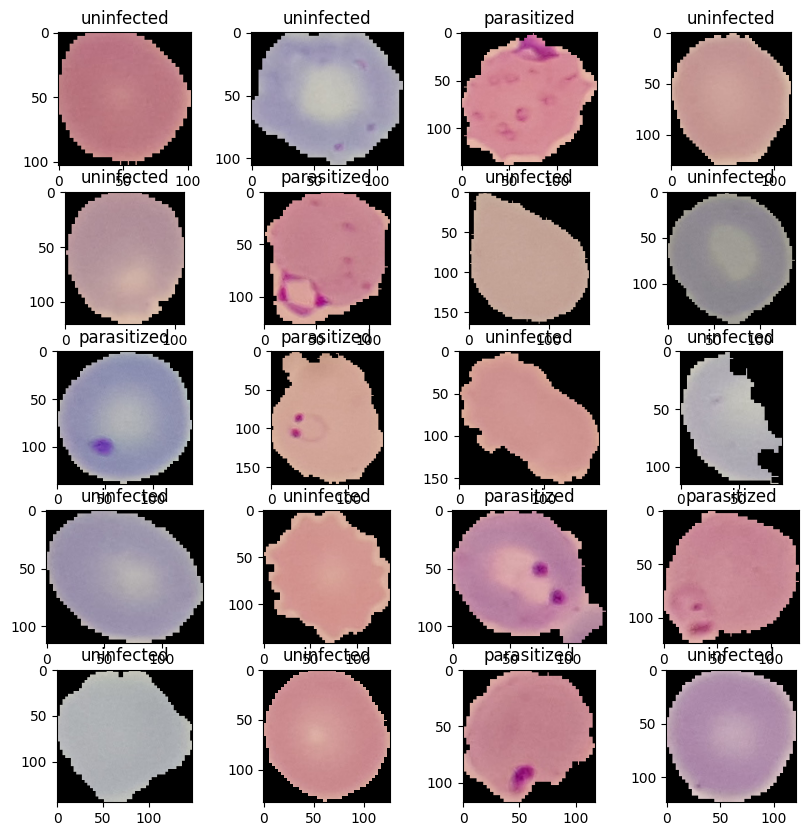

In [11]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(20)):
  ax=plt.subplot(5,4,i+1)
  plt.imshow(image)
  #print(label)
  plt.title(dataset_info.features["label"].int2str(label))

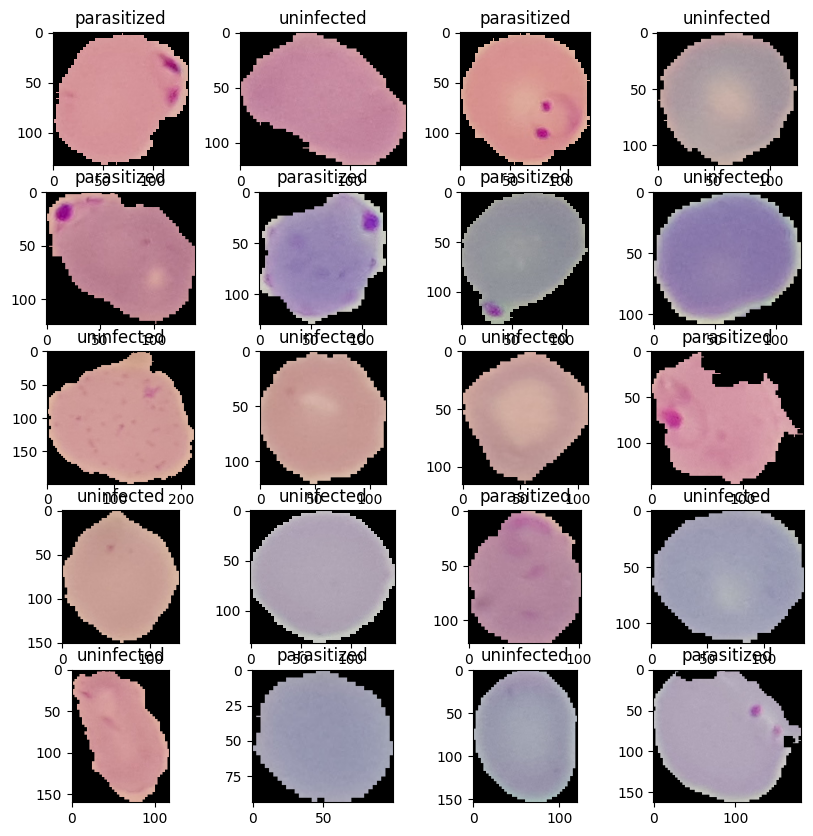

In [12]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(val_dataset.take(20)):
  ax=plt.subplot(5,4,i+1)
  plt.imshow(image)
  #print(label)
  plt.title(dataset_info.features["label"].int2str(label))

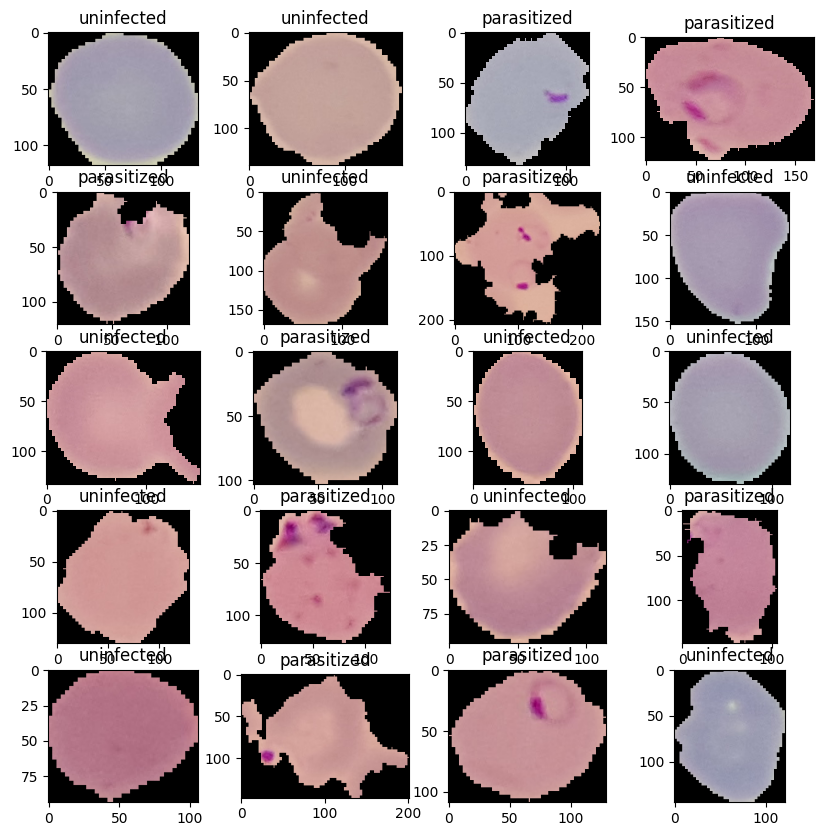

In [13]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(test_dataset.take(20)):
  ax=plt.subplot(5,4,i+1)
  plt.imshow(image)
  #print(label)
  plt.title(dataset_info.features["label"].int2str(label))

### Data pre-processing

In [14]:
def resize_rescale(image,label):
  return tf.image.resize(image,(224,224)),label

In [15]:
train_dataset=train_dataset.map(resize_rescale)

In [16]:
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)



```
# This is formatted as code
```

train_data=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
val_data=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_data=test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

### Model Building

In [19]:
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,3)),

    tf.keras.layers.Conv2D(filters=6,kernel_size=3,strides=1,padding="valid",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2),

    tf.keras.layers.Conv2D(filters=16,kernel_size=3,strides=1,padding="valid",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(1,activation="sigmoid")

])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 108, 108, 16)     64        
 hNormalization)                                                 
                                                        

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics="accuracy")

In [22]:
history=model.fit(train_data,validation_data=val_data,epochs=10,verbose=1)

Epoch 1/10
689/689 [==============================] - 57s 65ms/step - loss: 0.4250 - accuracy: 0.7930 - val_loss: 0.4613 - val_accuracy: 0.8588
Epoch 2/10
689/689 [==============================] - 44s 64ms/step - loss: 0.1995 - accuracy: 0.9306 - val_loss: 0.4017 - val_accuracy: 0.9234
Epoch 3/10
689/689 [==============================] - 43s 63ms/step - loss: 0.2114 - accuracy: 0.9310 - val_loss: 1.4721 - val_accuracy: 0.7935
Epoch 4/10
689/689 [==============================] - 45s 65ms/step - loss: 0.2255 - accuracy: 0.9242 - val_loss: 0.5943 - val_accuracy: 0.5252
Epoch 5/10
689/689 [==============================] - 42s 61ms/step - loss: 0.1726 - accuracy: 0.9443 - val_loss: 0.2015 - val_accuracy: 0.9321
Epoch 6/10
689/689 [==============================] - 45s 65ms/step - loss: 0.1539 - accuracy: 0.9506 - val_loss: 0.1340 - val_accuracy: 0.9590
Epoch 7/10
689/689 [==============================] - 42s 62ms/step - loss: 0.1650 - accuracy: 0.9428 - val_loss: 0.9368 - val_accuracy:

In [23]:
model.predict(test_data)

87/87 [==============================] - 14s 35ms/step


array([[1.7414216e-02],
       [2.2717284e-04],
       [1.6041871e-03],
       ...,
       [3.0273836e-04],
       [9.1051853e-01],
       [9.2072010e-01]], dtype=float32)

In [24]:
model.predict(test_data.take(1))

1/1 [==============================] - 11s 11s/step


array([[1.7414216e-02],
       [8.7980556e-01],
       [1.4789371e-01],
       [2.2717284e-04],
       [1.1511876e-01],
       [2.8771726e-02],
       [8.3211374e-01],
       [8.6109710e-01],
       [2.5288499e-04],
       [9.4069034e-01],
       [3.5383523e-01],
       [8.2127225e-01],
       [1.6041871e-03],
       [7.5837696e-01],
       [2.6893055e-01],
       [1.4678846e-02],
       [4.4621195e-04],
       [5.3947657e-01],
       [8.8297349e-04],
       [4.8057985e-01],
       [9.3886870e-01],
       [7.7418679e-01],
       [1.8263810e-03],
       [8.3963764e-01],
       [1.7556253e-04],
       [8.9167297e-01],
       [7.4898148e-01],
       [1.8392894e-03],
       [8.4160763e-01],
       [5.3891671e-01],
       [2.2196659e-04],
       [8.7926143e-01]], dtype=float32)

In [27]:
model.predict(test_dataset.batch(1).take(1))

1/1 [==============================] - 10s 10s/step


array([[0.84160745]], dtype=float32)